In [9]:
import pandas as pd

# save the patients_df
df = pd.read_csv('../data/msk_2024_mutations_filtered.csv')

# only select the columns we need first 263 columns and the last 2 columns
df = df.iloc[:, 266:].join(df.iloc[:, 1:3])
# df = df.iloc[:, 1:266]
df

,PIK3CA_Missense_Mutation_SNP_chr3,TP53_Missense_Mutation_SNP_chr17,GATA3_Frame_Shift_Ins_INS_chr10,ESR1_Missense_Mutation_SNP_chr6,ALK_Missense_Mutation_SNP_chr2,RNF43_Missense_Mutation_SNP_chr17,TSHR_Missense_Mutation_SNP_chr14,TP53_Nonsense_Mutation_SNP_chr17,IRS1_Missense_Mutation_SNP_chr2,NOTCH4_Missense_Mutation_SNP_chr6,...,ELF3_Splice_Site_SNP_chr1,HLA-B_Splice_Site_SNP_chr6,FANCA_Splice_Site_SNP_chr16,MDC1_In_Frame_Del_DEL_chr6,PREX2_Splice_Site_SNP_chr8,KMT2B_Splice_Site_SNP_chr19,NSD2_Frame_Shift_Ins_INS_chr4,MED12_Missense_Mutation_DNP_chr23,OS_STATUS,OS_MONTHS
0,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,13.906834
1,0,0,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,115.462887
2,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,13.610944
3,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,76.635532
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,60.756098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23536,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.753418
23537,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.983555
23538,0,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.493150
23539,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.032877


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index

# Extract features (mutation presence) and target (survival months & status)
X = df.drop(columns=["OS_MONTHS", "OS_STATUS"])
y_os = df["OS_MONTHS"].values  # Overall survival time
y_status = df["OS_STATUS"].values  # Overall survival status (0 = alive (censored), 1 = dead (event))

# Train-Validation-Test Split
X_train, X_temp, y_os_train, y_os_temp, y_status_train, y_status_temp = train_test_split(
    X, y_os, y_status, test_size=0.3
)
X_val, X_test, y_os_val, y_os_test, y_status_val, y_status_test = train_test_split(
    X_temp, y_os_temp, y_status_temp, test_size=0.5
)

# Convert to PyTorch tensors
X_train, y_os_train, y_status_train = map(torch.tensor, (X_train.values, y_os_train, y_status_train))
X_val, y_os_val, y_status_val = map(torch.tensor, (X_val.values, y_os_val, y_status_val))
X_test, y_os_test, y_status_test = map(torch.tensor, (X_test.values, y_os_test, y_status_test))

# Move to float tensors
X_train, X_val, X_test = X_train.float(), X_val.float(), X_test.float()
y_os_train, y_os_val, y_os_test = y_os_train.float(), y_os_val.float(), y_os_test.float()
y_status_train, y_status_val, y_status_test = y_status_train.float(), y_status_val.float(), y_status_test.float()

print(f"Train Size: {X_train.shape}, Validation Size: {X_val.shape}, Test Size: {X_test.shape}")


Train Size: torch.Size([16478, 1165]), Validation Size: torch.Size([3531, 1165]), Test Size: torch.Size([3532, 1165])


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# 0. MLP-Based Survival Model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1 = 256, hidden_dim2 = 256, dropout=0.3):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(hidden_dim2, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x.squeeze(-1)  # Ensure output is (batch,)

# 1. CNN-Based Survival Model
class CNNSurvival(nn.Module):
    def __init__(self, input_dim):
        super(CNNSurvival, self).__init__()
        # Treat the feature vector as a 1D "image" with one channel.
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64, 1)
        
    def forward(self, x):
        # x: (batch, input_dim)
        x = x.unsqueeze(1)  # (batch, 1, input_dim)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.global_pool(x)  # (batch, 64, 1)
        x = x.view(x.size(0), -1)  # (batch, 64)
        risk = self.fc(x)          # (batch, 1)
        return risk.squeeze(-1)

# 2. LSTM-Based Survival Model
class LSTMSurvival(nn.Module):
    def __init__(self, input_dim, hidden_size=64, num_layers=1):
        super(LSTMSurvival, self).__init__()
        # Each feature is treated as a time step with dimension=1.
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # x: (batch, input_dim) -> reshape to (batch, seq_len, 1)
        x = x.unsqueeze(-1)  # (batch, input_dim, 1)
        output, (hn, cn) = self.lstm(x)
        risk = self.fc(hn[-1])
        return risk.squeeze(-1)

# 3. Transformer-Based Survival Model
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)  # (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 == 1:
            # For odd d_model, handle the extra dimension
            pe[:, 1::2] = torch.cos(position * div_term)[:, :pe[:, 1::2].shape[1]]
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        # x: (batch, seq_len, d_model)
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len]
        return x

class TransformerSurvival(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2):
        super(TransformerSurvival, self).__init__()
        # Treat each feature as a time step with embedding dimension=1, then project to d_model.
        self.embedding = nn.Linear(1, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=input_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)
        
    def forward(self, x):
        # x: (batch, input_dim) -> reshape to (batch, seq_len, 1)
        x = x.unsqueeze(-1)  # (batch, input_dim, 1)
        x = self.embedding(x) # (batch, input_dim, d_model)
        x = self.pos_encoder(x)  # (batch, input_dim, d_model)
        x = x.transpose(0, 1)  # Transformer expects (seq_len, batch, d_model)
        x = self.transformer_encoder(x)  # (seq_len, batch, d_model)
        x = torch.mean(x, dim=0)  # Pool over sequence dimension -> (batch, d_model)
        risk = self.fc(x)         # (batch, 1)
        return risk.squeeze(-1)
    
# ---------------------------
# Model Architecture: GeneRiskNet
# ---------------------------
class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout_rate=0.3):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(dim, dim)
        self.bn1 = nn.BatchNorm1d(dim)
        self.fc2 = nn.Linear(dim, dim)
        self.bn2 = nn.BatchNorm1d(dim)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.fc1(x)))
        out = self.dropout(out)
        out = self.bn2(self.fc2(out))
        out = out + residual  # Residual connection
        return F.relu(out)

class GeneRiskNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_residual_blocks=3, dropout_rate=0.3):
        super(GeneRiskNet, self).__init__()
        self.fc_in = nn.Linear(input_dim, hidden_dim)
        self.bn_in = nn.BatchNorm1d(hidden_dim)
        self.res_blocks = nn.Sequential(*[ResidualBlock(hidden_dim, dropout_rate) for _ in range(num_residual_blocks)])
        self.fc_out = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        x = F.relu(self.bn_in(self.fc_in(x)))
        x = self.res_blocks(x)
        risk = self.fc_out(x)
        return risk.squeeze(-1)  # Output shape: (batch,)

In [12]:
# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

X_train, y_os_train, y_status_train = X_train.to(device), y_os_train.to(device), y_status_train.to(device)
X_val, y_os_val, y_status_val = X_val.to(device), y_os_val.to(device), y_status_val.to(device)
X_test, y_os_test, y_status_test = X_test.to(device), y_os_test.to(device), y_status_test.to(device)

# normalize the y_os_train, y_os_val, y_os_test using log1p
y_os_train = torch.log1p(y_os_train)
y_os_val = torch.log1p(y_os_val)
y_os_test = torch.log1p(y_os_test)

Using device: cuda


In [13]:
def cox_partial_likelihood_loss(risk_scores, times, events):
    """
    Computes the Cox Partial Likelihood loss for survival analysis.

    Parameters:
    - risk_scores: Tensor of predicted risk scores (higher = higher risk).
    - times: Tensor of survival times.
    - events: Tensor indicating event occurrence (1 = event, 0 = censored).

    Returns:
    - Negative log Cox partial likelihood loss.
    """
    # Sort survival times in descending order
    sorted_indices = torch.argsort(times, descending=True)
    sorted_risk = risk_scores[sorted_indices]
    sorted_events = events[sorted_indices]

    # Compute log-cumulative sum of exp(risk) -> LogSumExp trick for numerical stability
    risk_cumsum = torch.logcumsumexp(sorted_risk, dim=0)

    # Select only events (uncensored cases)
    event_mask = sorted_events == 1
    loss = -torch.sum(sorted_risk[event_mask] - risk_cumsum[event_mask])

    return loss / (event_mask.sum() + 1e-8)  # Normalize by number of events

def hinge_c_index_loss_vectorized(risk_scores, times, events, margin=1.0):
    """
    Computes a vectorized hinge loss for C-index optimization.

    Parameters:
    - risk_scores: Tensor of predicted risk scores (higher = higher risk). Shape: (N,)
    - times: Tensor of survival times. Shape: (N,)
    - events: Tensor indicating event occurrence (1 = event, 0 = censored). Shape: (N,)
    - margin: Margin for the hinge loss (default=1.0).

    Returns:
    - Hinge loss for C-index optimization.
    """
    # Create pairwise survival time differences: T_i - T_j
    time_diffs = times.unsqueeze(0) - times.unsqueeze(1)  # Shape: (N, N)

    # Create pairwise risk score differences: Risk_j - Risk_i
    risk_diffs = risk_scores.unsqueeze(1) - risk_scores.unsqueeze(0)  # Shape: (N, N)

    # Mask for valid comparable pairs: T_i > T_j and event_j == 1
    valid_pairs = (time_diffs > 0) & (events.unsqueeze(0) == 1)

    # Apply hinge loss to valid pairs: max(0, margin - (risk_j - risk_i))
    hinge_losses = torch.clamp(margin - risk_diffs, min=0)

    # Apply mask to keep only valid pairs
    hinge_losses = hinge_losses * valid_pairs.float()

    # Compute final loss (sum over valid pairs and normalize)
    loss = hinge_losses.sum() / (valid_pairs.sum() + 1e-8)  # Avoid division by zero

    return loss


def deepsurv_loss(risk_scores, times, events, model, l2_reg=1e-4):
    loss = cox_partial_likelihood_loss(risk_scores, times, events)
    l2_penalty = sum(param.norm(2) for param in model.parameters()) * l2_reg
    return loss + l2_penalty

# ---------------------------
# Vectorized Loss Functions
# ---------------------------

def cox_loss_vectorized(risk, time, event):
    """
    Vectorized Cox partial likelihood loss.
    
    risk: (batch,) tensor of predicted risk scores.
    time: (batch,) tensor of survival times (e.g., log-transformed).
    event: (batch,) tensor of event indicators (1 if event occurred, 0 if censored).
    """
    # Sort in descending order of time
    order = torch.argsort(time, descending=True)
    risk = risk[order]
    time = time[order]
    event = event[order]
    
    exp_risk = torch.exp(risk)
    # Cumulative sum over the risk set (for each sample i, sum exp(risk[j]) for j >= i)
    cum_sum = torch.cumsum(exp_risk, dim=0)
    diff = risk - torch.log(cum_sum + 1e-8)
    loss = -torch.sum(diff * event) / (torch.sum(event) + 1e-8)
    return loss

def c_index_ranking_loss_vectorized(risk, time, event, margin=0.0):
    """
    Optimized, vectorized pairwise ranking loss that approximates the c-index.
    
    risk: (batch,) predicted risk scores.
    time: (batch,) survival times.
    event: (batch,) event indicators.
    margin: margin for the loss (default=0.0).
    """
    # Compute pairwise differences: diff[i,j] = risk[j] - risk[i] - margin.
    diff = risk.unsqueeze(0) - risk.unsqueeze(1) - margin  # shape: (batch, batch)
    
    # Valid pair mask: valid if sample i had an event and time[i] < time[j]
    valid_mask = (time.unsqueeze(1) < time.unsqueeze(0)) & (event.unsqueeze(1) == 1)
    
    # Use softplus as a smooth approximation: log(1 + exp(diff))
    loss_matrix = F.softplus(diff)
    
    valid_loss = loss_matrix[valid_mask]
    count = valid_loss.numel()
    
    if count > 0:
        return valid_loss.sum() / count
    else:
        return torch.tensor(0.0, device=risk.device, requires_grad=True)
    
def hybrid_survival_loss(risk, time, event, alpha=0.5, margin=0.0):
    """
    Hybrid loss combining Cox partial likelihood and ranking loss.
    
    alpha: weight for the Cox loss (0 <= alpha <= 1).
        (1 - alpha) is the weight for the ranking loss.
    """
    loss_cox = cox_loss_vectorized(risk, time, event)
    loss_rank = c_index_ranking_loss_vectorized(risk, time, event, margin)

    # check scales
    # print(f"Loss Cox: {loss_cox.item()}, Loss Rank: {loss_rank.item()}")
    # print(f"Loss Cox Scale: {alpha * loss_cox.item()}, Loss Rank Scale: {(1 - alpha) * loss_rank.item()}")
    
    return alpha * loss_cox + (1 - alpha) * loss_rank

In [14]:
from torch.utils.data import Dataset, DataLoader

# Custom Dataset for Survival Data
class SurvivalDataset(Dataset):
    def __init__(self, X, time, event):
        self.X = X
        self.time = time
        self.event = event
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.time[idx], self.event[idx]

batch_size = 512  # Adjust based on your memory constraints

# Create dataset objects
train_dataset = SurvivalDataset(X_train, y_os_train, y_status_train)
val_dataset   = SurvivalDataset(X_val, y_os_val, y_status_val)
test_dataset  = SurvivalDataset(X_test, y_os_test, y_status_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# For validation and test we use full batches (since they are smaller)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [15]:
# -------------------------
# Select Model Type: "MLP", "CNN", "LSTM", or "Transformer"
# -------------------------
model_type = "MLP"  # Change to "MLP", "CNN", or "LSTM" as desired

# Assume X_train exists; if not, default to an example input dimension of 10.
input_dim = X_train.shape[1] if 'X_train' in globals() else 10

if model_type == "MLP":
    model = MLP(input_dim, hidden_dim1=128, hidden_dim2=64)
elif model_type == "CNN":
    model = CNNSurvival(input_dim)
elif model_type == "LSTM":
    model = LSTMSurvival(input_dim, hidden_size=64, num_layers=1)
elif model_type == "Transformer":
    model = TransformerSurvival(input_dim, d_model=64, nhead=4, num_layers=2)
elif model_type == "RES":
    model = GeneRiskNet(input_dim, hidden_dim=256, num_residual_blocks=3, dropout_rate=0.3)
else:
    raise ValueError("Invalid model type selected.")

print(model)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

MLP(
  (fc1): Linear(in_features=1165, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


In [16]:
from lifelines.utils import concordance_index
from sklearn.metrics import roc_auc_score

num_epochs = 200

train_losses, val_losses, val_c_indices, val_aurocs = [], [], [], []

loss_fn = deepsurv_loss  # Change to cox_loss_vectorized or deepsurv_loss as needed

for epoch in range(num_epochs):
    # ---- Training Phase ----
    epoch_loss = 0.0
    # model.train()
    # for batch_X, batch_time, batch_event in train_loader:
    #     batch_X, batch_time, batch_event = batch_X.to(device), batch_time.to(device), batch_event.to(device)
    #     optimizer.zero_grad()
    #     risk = model(batch_X)
    #     # loss = hybrid_survival_loss(risk, batch_time, batch_event, alpha=0.5, margin=0.0)
    #     loss = c_index_ranking_loss_vectorized(risk, batch_time, batch_event, margin=0.0)
    #     loss.backward()
    #     optimizer.step()
    #     epoch_loss += loss.item() * batch_X.size(0)
    # epoch_loss /= len(train_dataset)
        
    model.train()
    optimizer.zero_grad()
    risk = model(X_train)
    # loss = hybrid_survival_loss(risk, y_os_train, y_status_train, alpha=0.5, margin=0.0)
    # loss = loss_fn(risk, y_os_train, y_status_train)
    loss = loss_fn(risk, y_os_train, y_status_train, model, l2_reg=1e-4)
    loss.backward()
    optimizer.step()
    epoch_loss = loss.item()

    train_losses.append(epoch_loss)
    
    # ---- Validation Phase ----
    model.eval()
    with torch.no_grad():
        # We compute validation loss and predictions on the full validation set
        for val_X, val_time, val_event in val_loader:
            val_X, val_time, val_event = val_X.to(device), val_time.to(device), val_event.to(device)
            val_risk = model(val_X)
            # val_loss = loss_fn(val_risk, val_time, val_event)
            val_loss = loss_fn(val_risk, val_time, val_event, model, l2_reg=1e-4)
            
            # Convert log-transformed times back to original scale for c-index
            val_risk_np = val_risk.cpu().numpy()
            val_time_np = val_time.cpu().numpy()
            val_event_np = val_event.cpu().numpy()
            val_time_orig = np.expm1(val_time_np)
            c_index = concordance_index(val_time_orig, -val_risk_np, val_event_np)
            try:
                auroc = roc_auc_score(val_event_np, val_risk_np)
            except Exception:
                auroc = np.nan
    
    val_losses.append(val_loss.item())
    val_c_indices.append(c_index)
    val_aurocs.append(auroc)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss {epoch_loss:.4f}, Val Loss {val_loss.item():.4f}, "
            f"c-index {c_index:.4f}, AUROC {auroc:.4f}")

Epoch 10/200: Train Loss 8.9443, Val Loss 7.5732, c-index 0.6148, AUROC 0.6156
Epoch 20/200: Train Loss 8.8216, Val Loss 7.5622, c-index 0.6228, AUROC 0.6285
Epoch 30/200: Train Loss 8.7389, Val Loss 7.5449, c-index 0.6221, AUROC 0.6317
Epoch 40/200: Train Loss 8.6200, Val Loss 7.5308, c-index 0.6144, AUROC 0.6257
Epoch 50/200: Train Loss 8.4868, Val Loss 7.5215, c-index 0.6076, AUROC 0.6178
Epoch 60/200: Train Loss 8.3649, Val Loss 7.5440, c-index 0.6018, AUROC 0.6129
Epoch 70/200: Train Loss 8.2714, Val Loss 7.6414, c-index 0.5960, AUROC 0.6061
Epoch 80/200: Train Loss 8.1709, Val Loss 7.8203, c-index 0.5914, AUROC 0.6019
Epoch 90/200: Train Loss 8.1184, Val Loss 8.0267, c-index 0.5882, AUROC 0.5982
Epoch 100/200: Train Loss 8.0719, Val Loss 8.2523, c-index 0.5840, AUROC 0.5936
Epoch 110/200: Train Loss 8.0130, Val Loss 8.4245, c-index 0.5804, AUROC 0.5898
Epoch 120/200: Train Loss 7.9868, Val Loss 8.5593, c-index 0.5779, AUROC 0.5863
Epoch 130/200: Train Loss 7.9297, Val Loss 8.6612

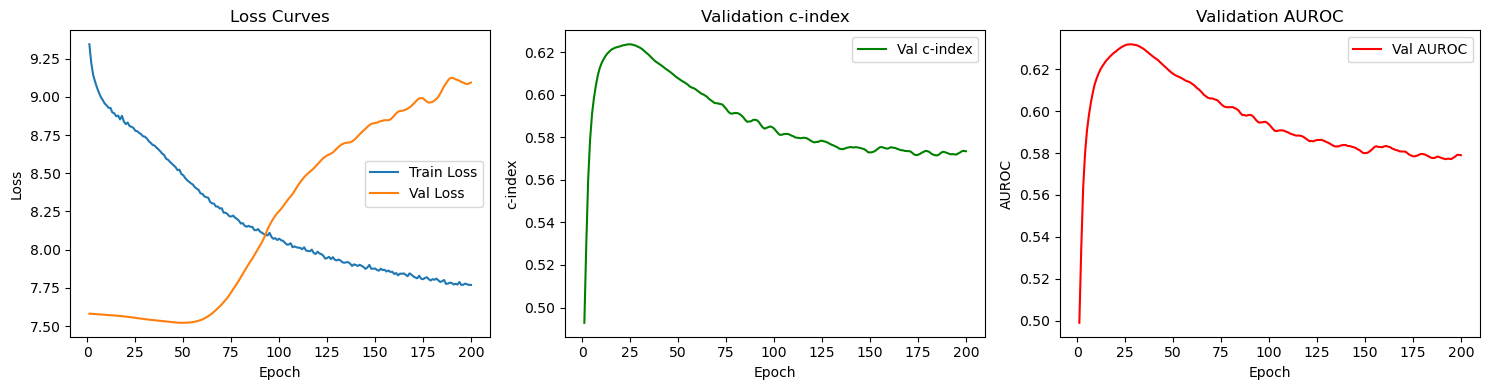

In [17]:
epochs_arr = np.arange(1, num_epochs + 1)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(epochs_arr, train_losses, label="Train Loss")
plt.plot(epochs_arr, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs_arr, val_c_indices, label="Val c-index", color='green')
plt.xlabel("Epoch")
plt.ylabel("c-index")
plt.title("Validation c-index")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs_arr, val_aurocs, label="Val AUROC", color='red')
plt.xlabel("Epoch")
plt.ylabel("AUROC")
plt.title("Validation AUROC")
plt.legend()

plt.tight_layout()
# save the plot
plt.savefig('../fig/survival_model_subtype_mlp.png')

plt.show()